# Predicting Car Prices Using KNN Algorithm
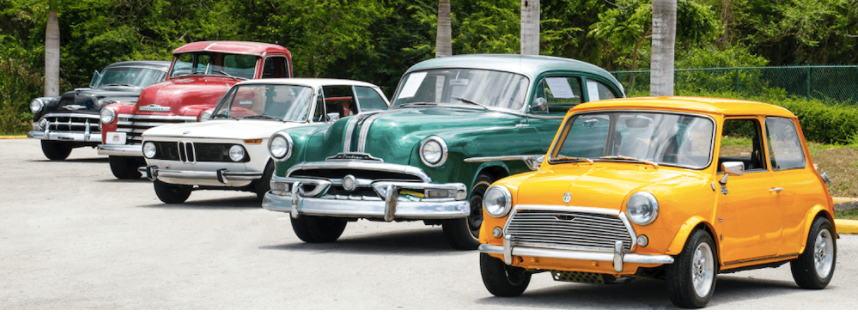

The goal of this project is to predict car's price using its attributes and applying k-nearest neighbour algorithm of machine learing.The dataset can be downloaded from __[Machinelearning Repository](https://archive.ics.uci.edu/ml/datasets/automobile)__ , where we can also find the data description.


## Data Exploration
The given data set does not contain the header row,so we will take the column names directly from the documentation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

columns = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors',
           'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width',
           'height', 'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size',
           'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm',
           'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv("imports-85.data", names = columns)
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [2]:
print("Number of rows:", cars.shape[0])
print("Number of columns:", cars.shape[1])
print("Number of missing values", cars.isnull().sum().sum())

Number of rows: 205
Number of columns: 26
Number of missing values 0


**Obsevations :**
* We donot have NAN values in the dataframe, however there are some missing values in normlaized-losses column represenred by '?', which we will have to fix later.
* There are 205 cars in dataframe.
* From 26 columns,we need those columns having numeric values, which can be used as featres.SO, first we should determine the numeric columns from the [ducumentation](https://archive.ics.uci.edu/ml/datasets/automobile) .

In [3]:
numeric_columns = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight',
                   'engine-size', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm',
                   'city-mpg', 'highway-mpg', 'price']

cars= cars[numeric_columns]
cars.shape

(205, 15)

## Data Cleaning

As we noticed in the earlier cell, in the normalized losses column some missing values are represnted by "?".There may be some other columns containing "?" values.So, we are now replacing "?" values with NAN and lets check the missing values again. 


In [4]:
# Repalcing "?" with NAN and coverting all numeric values to float.
cars = cars.replace("?",np.nan).astype("float")
print("% missing values after replacing ? values\n\n",round((cars.isnull().sum()*100)/len(cars)).astype(int))

% missing values after replacing ? values

 normalized-losses    20
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  2
stroke                2
compression-rate      0
horsepower            1
peak-rpm              1
city-mpg              0
highway-mpg           0
price                 2
dtype: int32


The normalized-losses column contains most of all missing values(20%), while other columns 0 - 2% .Dropping the rows having missing values doesn't make a sense, as we lose information from other columns which are almost complete.Dropping a whole column normalized-losses is also not a good idea,as 80% of its data is valid can be used for modelling.So,we are going to replace the missing values with mean value of the corresponding columns.

In [5]:
cars = cars.fillna(cars.mean())
print("Number of missing values :", cars.isnull().sum().sum())

Number of missing values : 0


Now, lets normalize the values in all the columns except the targer column price.

In [6]:
price = cars["price"]

# Normalizing the numeric values
cars = (cars-cars.min())/(cars.max() - cars.min())

# Substituting the initial price values
cars["price"] = price
cars.head(3)

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,0.125,0.262500,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,0.125,0.262500,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.433333,0.383333,0.517843,0.343396,0.100000,0.666667,0.125,0.441667,0.346939,0.166667,0.263158,16500.0


Now, the data is clean is ready for the further modelling, we are going to use two aprroaches **test/train validation** and **k-fold cross validation**.The steps we are going to follow in these aprroaches are as follow :
* Creating Univariate and Multivariate KNN Models
* estimating the error for each case.
* select the best model (one with less error)

## Test/Train Validation

**Creating Univariate Model**

Lets create simple univarite KNN models, for each numeric colum. WE are going to RMSE as an evaluation metric.

In [7]:
def knn_train_test(train_cols, target_col, df, k=5 ):
    '''Takes in a train column/columns, the target column, the dataframe, and the number of 
    the nearest neighbors. 
    Trains and tests the model using test/train validation approach. 
    Returns RMSE value.
    '''
    #one column case
    if type(train_cols) == str :
        X_train, X_test, y_train, y_test = train_test_split(df[[train_cols]],df[target_col] ,
                                                            test_size =0.5, random_state =1)
    #multi column case   
    elif type(train_cols) == list :
        X_train, X_test, y_train, y_test = train_test_split(df[train_cols], df[target_col],
                                                           test_size = 0.5, random_state = 1)
        
        
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return np.sqrt(mse)

#isolating all numeric columns except price
train_cols = cars.columns.drop("price")
default_k_rmse = {}

#creating univariate model for each column using default value of k
# And storing each value of RMSE in dictinary
for col in train_cols :
    rmse = knn_train_test(col,"price", cars)
    default_k_rmse[col] = round(rmse)

# sorting the dictionary in the ascending order of RMSE
import operator    
sorted_default_k_rmse = sorted(default_k_rmse.items(), key=operator.itemgetter(1))
sorted_default_k_rmse = dict(sorted_default_k_rmse)
sorted_default_k_rmse

{'engine-size': 3345,
 'curb-weight': 4172,
 'width': 4341,
 'city-mpg': 4433,
 'horsepower': 4539,
 'highway-mpg': 4696,
 'compression-rate': 5463,
 'wheel-base': 5640,
 'length': 5853,
 'bore': 6590,
 'normalized-losses': 6756,
 'stroke': 7004,
 'height': 7319,
 'peak-rpm': 7589}

Using the default number of neighbors (k=5), we can conclude that univariate model with  **engine-size**  variable performed the best.

Now, lets try to vary the values of k.

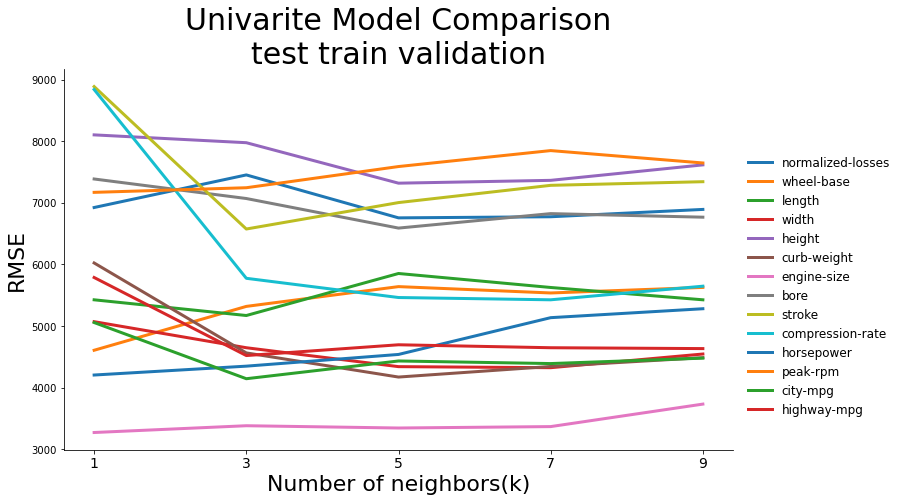

In [8]:
diff_k_rmses  = {}

#creting unvariate model for each column with different values of k
#And adding RMSE values to dictionary and plotting the results for all columns 
plt.figure(figsize=(12,7))
for col in train_cols:
    diff_k_rmses[col] = []
    for k in [1,3,5,7,9] :
        rmse = knn_train_test(col,"price",cars, k)
        diff_k_rmses[col].append(round(rmse))
    plt.plot(list(range(1,10,2)), diff_k_rmses[col], linewidth = 3)
plt.title("Univarite Model Comparison\ntest train validation",fontsize= 30)
plt.xlabel("Number of neighbors(k)",fontsize = 22)
plt.ylabel("RMSE", fontsize =22)
plt.xticks([1,3,5,7,9],fontsize =14)
plt.xticks(fontsize =14)
plt.legend(train_cols, frameon = False, bbox_to_anchor =(1.25,0.8),fontsize =12)
sns.despine()
plt.show()

From the chart above we can clearly say that , among all univariate models one with **engine-size** as column peformed the best again.For k=1 its showing lower error but there is no sinificant difference as compared to k=5.

In [9]:
k_1 = diff_k_rmses["engine-size"][0]
k_5 = diff_k_rmses["engine-size"][2]

print("RMSE for the univarite model:", "\nk=1 :",k_1,"\nk=5:",k_5)

RMSE for the univarite model: 
k=1 : 3272 
k=5: 3345


**Creating Multivariate Models**


In [10]:
diff_k_rmses_mean = {}
# Finding mean value of RMSE for each variable
for key in diff_k_rmses :
    diff_k_rmses_mean[key] = np.mean(diff_k_rmses[key])
    
#sorting the dictionary in ascending order of RMSE    
sorted_diff_k_rmses_mean = sorted(diff_k_rmses_mean.items(),key = operator.itemgetter(1))
sorted_diff_k_rmses_mean = dict(sorted_diff_k_rmses_mean)
sorted_diff_k_rmses_mean 


{'engine-size': 3420.0,
 'city-mpg': 4501.0,
 'width': 4586.0,
 'horsepower': 4702.0,
 'curb-weight': 4718.2,
 'highway-mpg': 4857.4,
 'wheel-base': 5346.0,
 'length': 5500.4,
 'compression-rate': 6230.0,
 'bore': 6927.8,
 'normalized-losses': 6960.0,
 'stroke': 7418.6,
 'peak-rpm': 7499.8,
 'height': 7675.8}

The five best features are 'engine-size','city-mpg','width','horsepower','curb-weight'.So,we can try the following combinations :

* 'engine-size',  'city-mpg'


* 'engine-size',  'city-mpg',  'width'


* 'engine-size',  'city-mpg',  'width',  'horsepower'


* 'engine-size',  'city-mpg',  'width',  'horsepower',  'curb-weight'

In [11]:
rmse_multivariate = []
for i in [2,3,4,5] :
    train_cols_list = list(sorted_diff_k_rmses_mean.keys())[:i]
    rmse = round(knn_train_test(train_cols_list,"price",cars))
    rmse_multivariate.append(rmse)
    
rmse_multivariate

[3320, 3896, 3760, 3677]

The top  models witl lowest RMSE are:

 1. With 2 best features **(engine-size, city-mpg)** and **RMSE=3320**
 
 2. With 5 best features **(engine-size, city-mpg, width, horsepower, curb-weight)** and **RMSE=3677**.
 
 3.  With 4 best features **(engine-size, city-mpg, width, horsepower)** and **RMSE=3760**.

Let's tune the hyperparmeter k,  for these models.

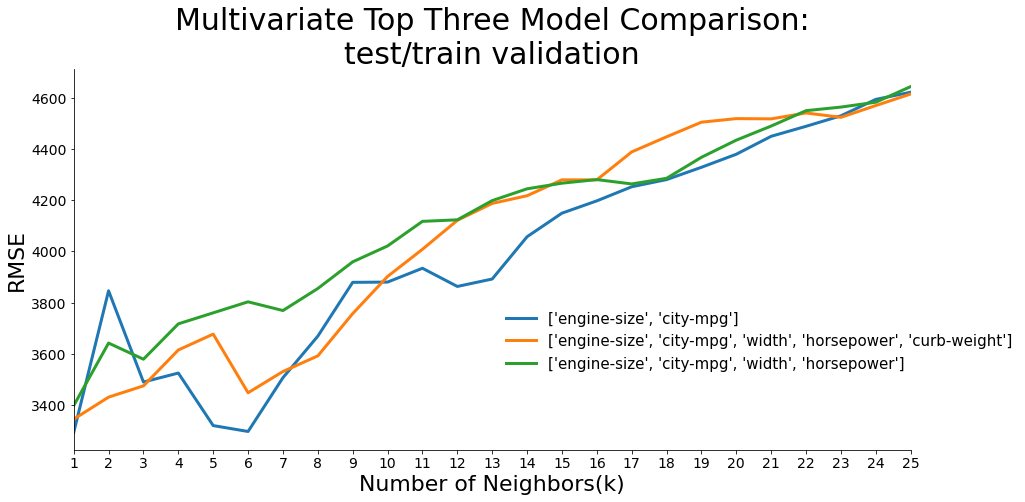

In [17]:
train_cols_list = [["engine-size","city-mpg"],
                  ["engine-size","city-mpg","width","horsepower","curb-weight"],
                  ["engine-size","city-mpg","width","horsepower"]]

diff_k_rmse_multivar = {}

plt.figure(figsize=(15,7))

for ind, lst in enumerate(train_cols_list):
    diff_k_rmse_multivar[ind+1] = []
    for k in list(range(1,26)):
        rmse = knn_train_test(lst, "price", cars,k)
        diff_k_rmse_multivar[ind+1].append(round(rmse))
    plt.plot(list(range(1,26)), diff_k_rmse_multivar[ind+1], linewidth = 3)
plt.title("Multivariate Top Three Model Comparison:\ntest/train validation", fontsize=30)
plt.xlabel("Number of Neighbors(k)", fontsize=22)
plt.ylabel("RMSE",fontsize=22)
plt.xlim(1,25)
plt.xticks(list(range(1,26)), fontsize = 14)
plt.yticks(fontsize=14)
plt.legend(train_cols_list, frameon = False, bbox_to_anchor = (0.5,0.4), fontsize =15)
sns.despine()
plt.show()

**Observations:**

* The 2-feature model remains the best one, with the optimal number of neighbors k equal to 6. For smaller values of k, with some fluctuations, the error is decreasing down to the minimum value at k=6, then it starts increasing

In [13]:
np.min(diff_k_rmse_multivar[1])

3293

* For the graphs with 4 features model and 5 features model, the lowest value of RMSE is at k=1, for higher values of k RMSE is increasing.



* In practice considering very few neighbors (i.e. too small values of k) implies a high impact of noise on the result.Instead, considering too many neighbors results in involving neighbors from other clusters (also with higher values of k error is increasing.) 

So, far our results are :

* **Univariate Model** 

   * Default k = 5 : engine-size (RMSE = 3345)
   
   * Optimal k = 1 : engine-size (RMSE = 3272)
   
   
* **Multivariate Model**
  
  * Default k = 5 : engine-size, city-mpg (RMSE = 3320)
  
  * Optimal k = 5 : engine-size, city-mpg (RMSE = 3293)
  
  
In general the difference between the RMSE values is not considerable.Univariate model with engine-size and k = 1 has the lowest RMSE, however as mentioned earlier considering too few neigbors leads to noise influence.

Hence, the safer choice is multivariate model with engine-size, city-mpg and k =6 (RMSE = 3293).

## K Fold Cross Validation

 **Creating Univarite models**
 
 Now, we will use k-fold cross validation approach to create KNN univarite model.This time we will not vary the number of neighbors and keep it to default value k=5.Instead, we will vary the number of folds. 

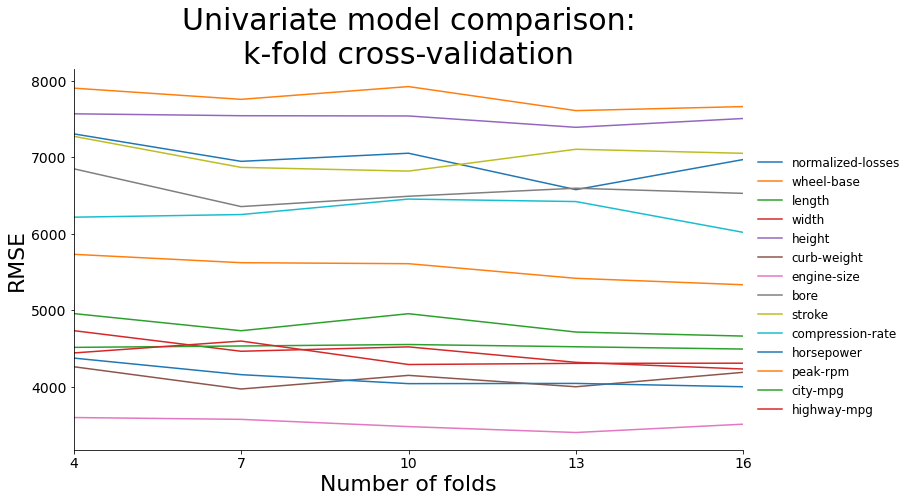

{'engine-size': 3517.8481732657674,
 'curb-weight': 4118.2015886861855,
 'horsepower': 4127.664172446824,
 'highway-mpg': 4392.57136430246,
 'width': 4457.674357793451,
 'city-mpg': 4526.697891814486,
 'length': 4807.43778046198,
 'wheel-base': 5544.387677175381,
 'compression-rate': 6272.761459738684,
 'bore': 6563.917848060123,
 'normalized-losses': 6970.022893118019,
 'stroke': 7022.928823221091,
 'height': 7508.580384575473,
 'peak-rpm': 7769.6606197243555}

In [14]:
def k_fold_cross_val(n_splits,train_cols,target_col,df,k=5):
    '''Takes in the number/numbers of folds as an integer, a train
    column/columns, the target column, the dataframe, and the number of the nearest neighbors.
    Trains and tests the model using k-fold cross-validation approach. 
    Returns RMSE value.
    '''
    kf = KFold(n_splits, shuffle = True, random_state=1)
    knn = KNeighborsRegressor(n_neighbors=k)
            
    if type(train_cols) == str :
        mses = cross_val_score(knn, df[[train_cols]], df["price"],
                                      scoring = "neg_mean_squared_error", cv = kf)
                
    elif type(train_cols) == list :
        mses = cross_val_score(knn, df[train_cols], df["price"],
                                      scoring = "neg_mean_squared_error", cv = kf)
    return np.mean(np.sqrt(abs(mses)))

rmse_kfold_univar = {}
plt.figure(figsize=(12,7))

for col in train_cols :
    rmse_kfold_univar[col] = []
    for n in [4,7,10,13,16] :
        rmse = k_fold_cross_val(n,col,"price",cars)
        rmse_kfold_univar[col].append(rmse)
    plt.plot(list(range(4,17,3)),rmse_kfold_univar[col])
plt.title('Univariate model comparison:\nk-fold cross-validation', fontsize=30)
plt.xlabel('Number of folds', fontsize=22)
plt.ylabel('RMSE', fontsize=22)
plt.xticks([4, 7, 10, 13, 16], fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(4,16)
plt.legend(train_cols, frameon=False, bbox_to_anchor=(1.25, 0.8), fontsize=12)
sns.despine()
plt.show()

rmse_kfold_univar_mean = {}
for key in rmse_kfold_univar :
    rmse_kfold_univar_mean[key] = np.mean(rmse_kfold_univar[key])
    
sorted_rmse_kfold_univar_mean = sorted(rmse_kfold_univar_mean.items(), key =operator.itemgetter(1))  
sorted_rmse_kfold_univar_mean = dict(sorted_rmse_kfold_univar_mean)
sorted_rmse_kfold_univar_mean 
                    
                
                
                

From the graph and mean values of RMSE, we can say that once again the univariate model with engine-size gives the lowest RMSE for any number of folds (minimum error obtained with 13 number of folds) and hence performs the best of all for predicting car prices.



## Creating Multivariate Models

Let's create multivarite models.We will follow the following algorithm:

* Select 5 best features from the previous step: engine-size, curb-weight, horsepower, highway-mpg, and width.

* Try different combinations of them: 2, 3, 4, and 5 best features:
      * engine-size, curb-weight
      * engine-size, curb-weight, horsepower
      * engine-size, curb-weight, horsepower, highway-mpg
      * engine-size, curb-weight, horsepower, highway-mpg, width.
      
* Vary the number of folds (the same selection as we used for the univariate models: 4, 7, 10, 13, 16).

* Vary the number of the nearest neighbors from 3 to 10.

* Train and test a multivariate KNN model for each combination of features, using different numbers of folds and nearest   neighbors.

* Visualize the results (each figure will represent all 4 combinations of features, with all the options of the fold numbers from the selection and a fixed number of the nearest neighbors).

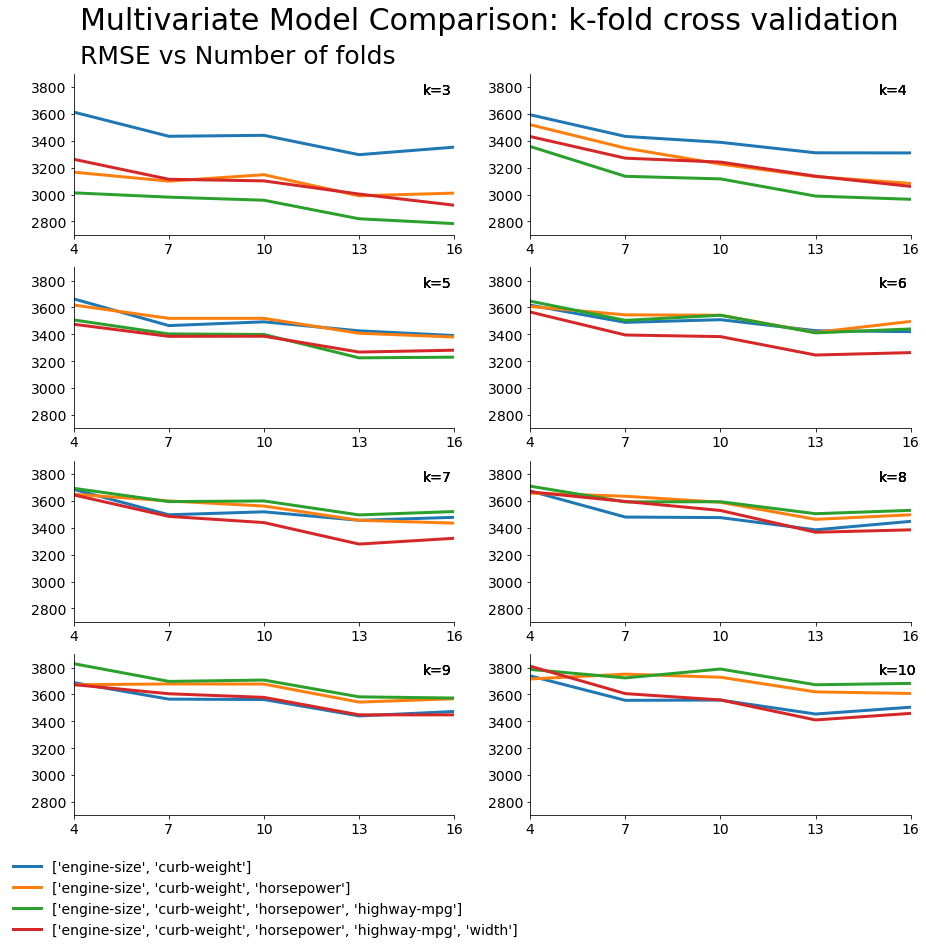

In [15]:
train_cols = [['engine-size','curb-weight'],
             ['engine-size','curb-weight','horsepower'],
             ['engine-size','curb-weight','horsepower','highway-mpg'],
             ['engine-size','curb-weight','horsepower','highway-mpg','width']]

rmse_kfold_multivar = {}
plt.figure(figsize=(15,35))

for k in range(3,11) :
    plt.subplot(10,2,k-2) 
    for ind,lst in enumerate(train_cols) :
        rmse_kfold_multivar[ind+1] = []
        for n in [4,7,10,13,16] :
            rmse = k_fold_cross_val(n,lst,"price", cars, k)
            rmse_kfold_multivar[ind+1].append(round(rmse))
        plt.plot([4,7,10,13,16],rmse_kfold_multivar[ind+1], linewidth=3 )
        plt.text(15,3750,f'k={k}', fontsize = 14)
    if k == 10 :
        plt.legend(train_cols, frameon =  False, bbox_to_anchor = (0,-0.2), fontsize =14)
        plt.text(-10.2,8550, 'Multivariate Model Comparison: k-fold cross validation',fontsize = 30)
        plt.text(-10.2,8300, 'RMSE vs Number of folds',fontsize = 25)
    plt.xticks([4,7,10,13,16], fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlim(4,16)
    plt.ylim(2700,3900)
    sns.despine()
plt.show()



**Observations** :

* Increasing the number of folds leads to decreasing the error of price prediction on the test set for all the models, in this case, we overfit the model. However, such a model can demonstrate poor performance on completely new data.


* Increasing the number of the nearest neighbors leads to the increase of the error of price prediction (because of involving irrelevant neighbors). It's especially evident for the models with more features that are more sensitive to the changes of k. To reduce the error, keeping at the same time as many features for price prediction as reasonably possible, we have to consider relatively low k values.


* It's important to remember that we have only 205 entries in our dataset, that is not too many. To avoid model overfitting, we would better go for relatively low values of the number of folds.

Hence, the model with 4 best features (**engine-size, curb-weight, horsepower, and highway-mpg**), **7 folds and 4 nearest neighbors** is an excellent model, among all the models we created so far it has the lowest RMSE .

In [16]:
k_fold_cross_val(7,['engine-size','curb-weight','horsepower','highway-mpg'],"price",cars,4)

3136.3614543358576

## Conclusion

In this project, we used the KNN algorithm, particularly test/train validation and k-fold cross-validation, to create univariate and multivariate ML models for predicting a car's market price based on its attributes. We tried different features and their combinations, different numbers of folds and the nearest neighbors. The main idea was to reduce the error of prediction on the test data and to ensure model feasibility for future unknown data (by avoiding model overfitting).

As a result, the best predictive capacity for the car price was obtained for a multivariate model with 4 features (engine-size, curb-weight, horsepower, and highway-mpg) created by applying k-fold cross-validation with 7 folds, and 4 nearest neighbors. Its main advantages are:

* The lowest RMSE value while still having reasonable values of the number of folds and the nearest neighbors,using several price-influencing features.

* k-fold cross-validation is less biased than test/train validation since it takes advantage of a larger proportion of the data for training while still iterating through different data subsets.

This model, as well as the others that have demonstrated the lowest error, has engine-size as one of the features. Hence, the engine size is one of the most influencing factors on the car price.